### apriltags and poses 20240306 CJH
* intended to teach the basics of apriltags and pose updates
* using https://www.chiefdelphi.com/t/wpilib-apriltagdetector-sample-code/421411/44?page=3 as a template for the geometry

In [2]:
import robotpy_apriltag as ra  # this comes with the robotpy package, you may need to add apriltags to the project.toml and sync to get it
import matplotlib.pyplot as plt  # you always need matplotlib
import cv2
import numpy as np
import pandas as pd
import wpimath.geometry as geo
from wpimath import objectToRobotPose


#### get yourself a layout of tags you can query for poses

In [3]:
# this is how you load in a layout
field = ra.AprilTagField.k2024Crescendo
layout = ra.loadAprilTagLayoutField(field=field)

In [4]:
# example calls
tag = layout.getTags()[0]
tag.pose.x, tag.pose.translation(), tag.pose.rotation()

(15.079471999999997,
 Translation3d(x=15.079472, y=0.245872, z=1.355852),
 Rotation3d(x=0.000000, y=0.000000, z=2.094395))

In [5]:
tag.pose, tag.pose.toPose2d()

(Pose3d(Translation3d(x=15.079472, y=0.245872, z=1.355852), Rotation3d(x=0.000000, y=0.000000, z=2.094395)),
 Pose2d(Translation2d(x=15.079472, y=0.245872), Rotation2d(2.094395)))

In [6]:
# let's see them all - remember rotations are in radians, 0 faces to the right, CCW is positive, so #6 is at -pi/2
tag_layout = {} 
for tag in layout.getTags():
    # print (f'ID:{tag.ID:02d}  pose: {tag.pose}')
    tag_layout.update({tag.ID:{'ID':tag.ID, 'X':tag.pose.x, 'Y':tag.pose.y, 'Z':tag.pose.z, 'Z_DEG':tag.pose.rotation().z*180/3.1459,
                              'X_ROT':tag.pose.rotation().x, 'Y_ROT':tag.pose.rotation().x, 'Z_ROT':tag.pose.rotation().z,}})
df = pd.DataFrame(tag_layout).transpose()
df

,ID,X,Y,Z,Z_DEG,X_ROT,Y_ROT,Z_ROT
1,1.0,15.079472,0.245872,1.355852,119.835697,0.0,0.0,2.094395
2,2.0,16.185134,0.883666,1.355852,119.835697,0.0,0.0,2.094395
3,3.0,16.579342,4.982718,1.451102,179.753545,0.0,0.0,3.141593
4,4.0,16.579342,5.547868,1.451102,179.753545,0.0,0.0,3.141593
5,5.0,14.700758,8.204200,1.355852,-89.876773,0.0,0.0,-1.570796
6,6.0,1.841500,8.204200,1.355852,-89.876773,0.0,0.0,-1.570796
7,7.0,-0.038100,5.547868,1.451102,0.000000,0.0,0.0,0.000000
8,8.0,-0.038100,4.982718,1.451102,0.000000,0.0,0.0,0.000000
9,9.0,0.356108,0.883666,1.355852,59.917848,0.0,0.0,1.047198
10,10.0,1.461516,0.245872,1.355852,59.917848,0.0,0.0,1.047198


#### plot of the apriltag locations in crescendo 

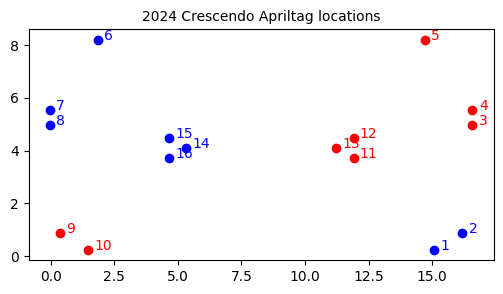

In [7]:
# make a quick plot of the locations of each tag
fig, ax = plt.subplots(1,1,figsize = (6,3))
for field_tag in layout.getTags():
    color = 'b' if field_tag.ID in [1, 2, 6, 7, 8, 14, 15, 16] else 'r'
    ax.scatter(field_tag.pose.x, field_tag.pose.y, c=color)
    ax.text(field_tag.pose.x + 0.25, field_tag.pose.y, str(field_tag.ID), c=color)
ax.set_title('2024 Crescendo Apriltag locations', fontsize=10);

In [8]:
# if you want a tag's pose, just ask for it by ID
layout.getTagPose(6)

Pose3d(Translation3d(x=1.841500, y=8.204200, z=1.355852), Rotation3d(x=0.000000, y=-0.000000, z=-1.570796))

#### set up an apriltag detector and a pose estimator

In [76]:
# set up an apriltag detector
camera = 'c920'
detector = ra.AprilTagDetector()
detector.addFamily('tag16h5')
# need to calculate this based on camera and resolution
if camera == 'lifecam':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1524, fx=342.3, fy=335.1, cx=320/2, cy=240/2)
elif camera == 'c920':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1524, fx=439.5, fy=439.9, cx=640/2, cy=360/2) # logitech at 640x360
else:
    raise ValueError('invalid camera')
estimator = ra.AprilTagPoseEstimator(config)  # 6 inches is 0.15m

#### read an image and extract the pose from the camera to the tag

In [77]:
image = cv2.imread('cal_images/logitech_c920_id06.jpg', cv2.COLOR_RGB2BGR)
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

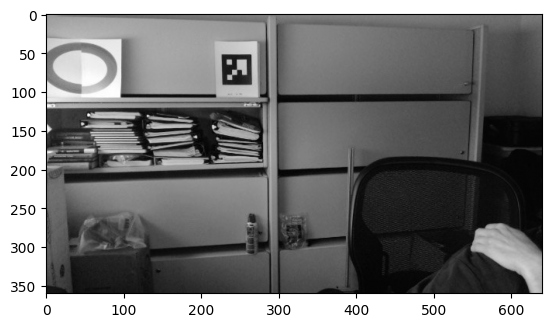

In [78]:
plt.imshow(grey_image, cmap='gray')

In [79]:
tags = detector.detect(grey_image)
tags = [tag for tag in tags if tag.getHamming()< 2 and tag.getDecisionMargin() > 20]
tags[0]

<AprilTagDetection tag_family=tag16h5 tag_id=6 hamming=0 decision_margin=148.49017333984375 center=Point(x=246.19671902428047, y=72.7810947424029)>

In [80]:
tags[0].getHomography()

(19.690491879169826,
 1.2683901531501114,
 246.19671902428047,
 0.16535277142952146,
 19.777562697140567,
 72.7810947424029,
 0.0022583966279222842,
 0.0031864302377089663,
 1.0)

In [81]:
poses = [estimator.estimate(tag) for tag in tags]

#### this is the pose of the camera relative to the tag - need to experiment a bit with positions to get it
* x (is negative if camera on right? or is this because we're twisted too?) - like a strafe 
* y is negative (because camera is below the tag?) - like a relative height
* z is distance so we should always be positive there 

In [82]:
pose = poses[0]
pose

Transform3d(Translation3d(x=-0.294215, y=-0.427026, z=1.752044), Rotation3d(x=0.075290, y=-0.051458, z=-0.014501))

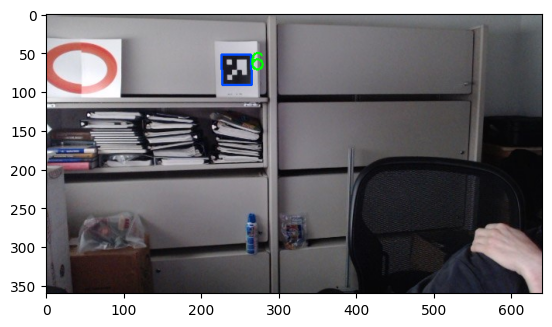

In [83]:
# see that we have the right one 
tag = tags[0]
color = (255, 75, 0) if tag.getId() in [1, 2, 6, 7, 8, 14, 15, 16] else (0, 0, 255)  # blue and red tags - opencv is BGR
center = tag.getCenter()
center = [int(center.x), int(center.y)]
corners = np.array(tag.getCorners([0] * 8)).reshape((-1, 1, 2)).astype(dtype=np.int32)
image = cv2.polylines(image, [corners], isClosed=True, color=color, thickness=2)
image = cv2.putText(image, f'{tag.getId():2d}', center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#### now we have to do some transforms to get the field pose of the camera, robot, and the tag

In [84]:
# camera is facing the tag, so we have to flip some things
pose_camera = geo.Transform3d(
    geo.Translation3d(pose.x, pose.y, pose.z),
    geo.Rotation3d(-pose.rotation().x -np.pi, -pose.rotation().y, pose.rotation().z - np.pi)
)

In [85]:
pose, pose_camera

(Transform3d(Translation3d(x=-0.294215, y=-0.427026, z=1.752044), Rotation3d(x=0.075290, y=-0.051458, z=-0.014501)),
 Transform3d(Translation3d(x=-0.294215, y=-0.427026, z=1.752044), Rotation3d(x=3.066303, y=0.051458, z=3.127091)))

In [86]:
# OpenCV and WPILib estimator layout of axes is EDN and field WPILib is NWU; need x -> -y , y -> -z , z -> x and same for differential rotations
pose_nwu = geo.CoordinateSystem.convert(pose_camera, geo.CoordinateSystem.EDN(), geo.CoordinateSystem.NWU())
#print(pose_nwu)
# this may be buggy, according to OP, so try 
old = geo.CoordinateSystem.EDN()
new = geo.CoordinateSystem.NWU()
pose_nwu2 = geo.Transform3d(
    geo.CoordinateSystem.convert(pose_camera.translation(), old, new),
    geo.CoordinateSystem.convert(geo.Rotation3d(), new, old) + (geo.CoordinateSystem.convert(pose_camera.rotation(), old, new)),
)
#print(pose_nwu2)
# nope - they both give the same answer

In [87]:
# camera pointing forwards on robot, at front and 6" off the ground
camera_in_robot_frame = geo.Transform3d(geo.Translation3d(0.2, 0, 0.15), geo.Rotation3d(0, 0, 0))
camera_in_robot_frame

Transform3d(Translation3d(x=0.200000, y=0.000000, z=0.150000), Rotation3d(x=0.000000, y=0.000000, z=0.000000))

In [88]:
tag_in_field_frame = layout.getTagPose(tag.getId())
# tag_in_field_frame = layout.getTagPose(1)  # can play with where the robot shows up if you change this number

In [89]:
robot_in_field_frame = objectToRobotPose(tag_in_field_frame,  pose_nwu2,  camera_in_robot_frame);

In [90]:
print(f'pose: {pose}\npose_camera: {pose_camera}\npose_nwu: {pose_nwu}\ntag_in_field_frame: {tag_in_field_frame}\nrobot_in_field_frame: {robot_in_field_frame}')

pose: Transform3d(Translation3d(x=-0.294215, y=-0.427026, z=1.752044), Rotation3d(x=0.075290, y=-0.051458, z=-0.014501))
pose_camera: Transform3d(Translation3d(x=-0.294215, y=-0.427026, z=1.752044), Rotation3d(x=3.066303, y=0.051458, z=3.127091))
pose_nwu: Transform3d(Translation3d(x=1.752044, y=0.294215, z=0.427026), Rotation3d(x=0.014523, y=0.074536, z=-3.089048))
tag_in_field_frame: Pose3d(Translation3d(x=1.841500, y=8.204200, z=1.355852), Rotation3d(x=0.000000, y=-0.000000, z=-1.570796))
robot_in_field_frame: Pose3d(Translation3d(x=2.026534, y=6.201884, z=0.924009), Rotation3d(x=0.010622, y=0.075190, z=1.519192))


#### now plot where the robot is on the field based on the tag
* note matplotlib and the pose have different definitions of zero

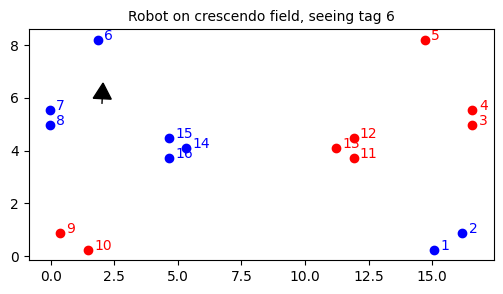

In [91]:
# make a quick plot of the locations of each tag
fig, ax = plt.subplots(1,1,figsize = (6,3))
for field_tag in layout.getTags():
    color = 'b' if field_tag.ID in [1, 2, 6, 7, 8, 14, 15, 16] else 'r'
    ax.scatter(field_tag.pose.x, field_tag.pose.y, c=color)
    ax.text(field_tag.pose.x + 0.25, field_tag.pose.y, str(field_tag.ID), c=color)
# show the robot as a triangle - looks like CCW is positive
rotation = -90 + np.rad2deg(robot_in_field_frame.rotation().z)  # matplotlib angle of the triangle is 0 up, robot is 0 right
ax.plot(robot_in_field_frame.x, robot_in_field_frame.y, marker=(3, 0, rotation), color='k', markersize=15, linestyle='None')
ax.plot(robot_in_field_frame.x, robot_in_field_frame.y, marker=(2, 0, rotation), color='k', markersize=15, linestyle='None')
ax.set_title(f'Robot on crescendo field, seeing tag {tag.getId()}', fontsize=10);

#### now update the odometry based on this pose (if correct)

In [92]:
# todo

Text(0.5, 1.0, 'compressed image: 8450')

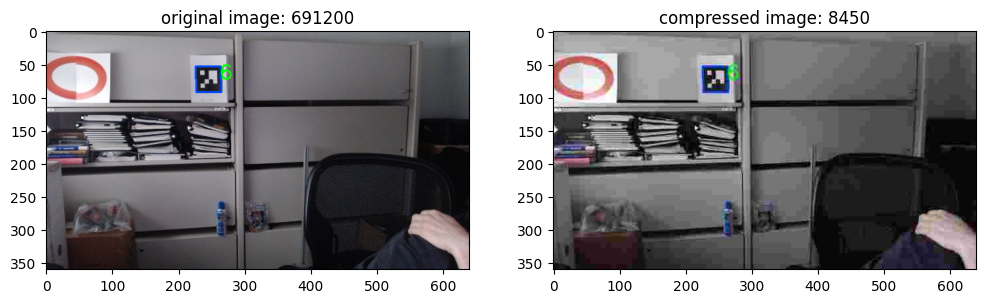

In [93]:
compression = 1
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title(f'original image: {image.size}')
ret, im_compressed = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 10])
axs[1].imshow(cv2.cvtColor(cv2.imdecode(im_compressed, 1),cv2.COLOR_BGR2RGB))
axs[1].set_title(f'compressed image: {im_compressed.size}')

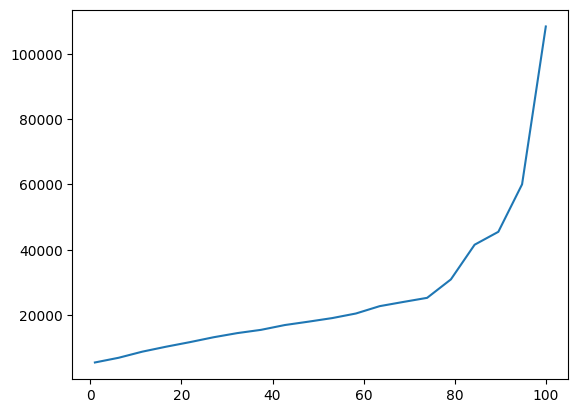

In [94]:
x = np.linspace(1, 100, 20)
y = [cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, int(i)])[1].size for i in x]
plt.plot(x,y)

In [95]:
-60 + 180

120

In [62]:
60 + 180

240

In [63]:
240 - 360

-120

#### find the closest stage (or whatever)

In [64]:
import robotpy_apriltag as ra  # this comes with the robotpy package, you may need to add apriltags to the project.toml and sync to get it
import wpimath.geometry as geo

In [65]:
# this is how you load in a layout
field = ra.AprilTagField.k2024Crescendo
layout = ra.loadAprilTagLayoutField(field=field)

In [66]:
# make up a pose - irl would be the pose of the robot
x = 15
y = 6
my_location = geo.Pose2d(geo.Translation2d(x,y), geo.Rotation2d(0))

In [67]:
# get the tags
stage_tags = [11,12,15,16]
stage_poses = [layout.getTagPose(tag).toPose2d() for tag in stage_tags]

In [68]:
# find the tag distances
distances = [my_location.translation().distance(pose.translation()) for pose in stage_poses]
distances

[3.8483836168126486,
 3.4403057844726534,
 10.466937389540648,
 10.608069140425133]

In [69]:
# sort the tags based on the distances to them
combined = list(zip(stage_tags, distances))
combined.sort(key=lambda x: x[1])
sorted_tags, sorted_distances = zip(*combined)
print("Sorted tags:", sorted_tags)
print("Sorted distances:", sorted_distances)

Sorted tags: (12, 11, 15, 16)
Sorted distances: (3.4403057844726534, 3.8483836168126486, 10.466937389540648, 10.608069140425133)


In [70]:
# winner is sorted_tags[0]
sorted_tags[0]

12